# PINNS

This notebook is an introduction to PINNS and how to implement physics-based losses using Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

torch.manual_seed(270)
random.seed(270)

In [2]:
# Set to True to enable interactive plots
interactive_plots = False
if interactive_plots: import plotly.express as px

## Problem definition

In the following, we want to estimate a function $u$ using a physics informed loss based on a PDE that needs to be satisfied.

The definition of u is as follows  :

$u(x, y, t) := \begin{bmatrix} x^2 + 6xyt + 2y^2 \\ 2x + 6yt\end{bmatrix} = \begin{bmatrix}u_x \\ u_y\end{bmatrix}$

which satisfies the following PDE: $\partial_x u_x = u_y$

It's the satisfaction of this last equation that we will incorporate as an additional constraint into our network.

Let's first define u and plot what it looks like:

In [3]:
def u(x):
    in_1 = x[:, 0]**2 + 6*x[:, 0]*x[:, 1]*x[:, 2] + 2*x[:, 1]**2
    in_2 = 2*x[:, 0] + 6*x[:, 1]*x[:, 2]
    in_1 = in_1.view(-1, 1)
    in_2 = in_2.view(-1, 1)

    return torch.cat([in_1, in_2], 1)

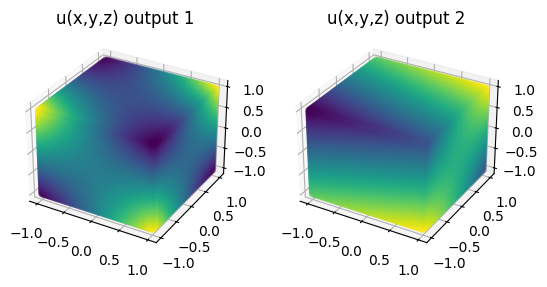

In [4]:
# plotting the function u
if interactive_plots:
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = u(input)
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 0])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 1')
    fig.update_layout(template="plotly_dark")
    fig.show()
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 1])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 2')
    fig.update_layout(template="plotly_dark")
    fig.show()
else:
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = u(input)
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 0])
    ax.set_title('u(x,y,z) output 1')
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 1])
    ax.set_title('u(x,y,z) output 2')
    plt.show()

So how do we incorporate the PDE constraint in our loss ?

Let's first remember that in a ML task, we want to optimize the following loss function:

$$
L_{ML}(\theta) := \dfrac{1}{N} \sum_{i=1}^N || \hat{\mathbf{u}}_\theta(\mathbf{x}_i) - \mathbf{u}(\mathbf{x}_i)||
$$

Where $\mathbf{x}_i$ are our feature samples, $\mathbf{u}$ is the function we want to estimate and $\hat{\mathbf{u}}_\theta$ is the regressor we are training.

From this, we can simply extend our loss to include a physics informed part and write it as follows:

$$
L(\theta) := L_{LM}(\theta) + \lambda_{PDE} L_{PDE}(\theta)
$$

With $\lambda_{PDE}$ being a scalar hyperparameter and
\begin{equation}
L_{PDE}(\theta) := \dfrac{1}{M} \sum_{j=1}^M || \partial_x \hat{\mathbf{u}}_\theta(\mathbf{x}_j)_x - \hat{\mathbf{u}}_\theta(\mathbf{x}_j)_y||
\end{equation}

Where here we can use a different set of input features $\mathbf{x}_j$ !

---

## Implementation in Pytorch

### Experimenting using autograd

Autograd is the tool that allows us to compute gradients with respect to input features.

It relies completely on the chain rule, and uses a computation graph to store serial operations.

If you want to learn more about it, you can check the following link: https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

A thing to remember when dealing with ML problems is that we usually scale the input (and sometimes the outputs as well) of our data.

So when we consider an input feature we want to differentiate with respect to, we need to make sure we differentiate with respect to the true unscaled version of our input !

Another thing to remember is that autograd only computes gradients with respect to leaf nodes. Therefore, when differentiating with respect to the unscaled data, it is necessary to create a new leaf node.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- Here is a simple pipelines:

In [6]:
x = torch.ones(3, 1).detach().requires_grad_(True).to(device)
y = 3*torch.ones(3, 1).detach().requires_grad_(True).to(device)
output = torch.cat([torch.tensor(5).to(device)*x**2, y, x*y], 1)

ux, uy, uz = output[:,0], output[:,1], output[:,2]
torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
torch.autograd.grad(uz, x, grad_outputs=torch.ones_like(uz), create_graph=True)[0]

tensor([[3.],
        [3.],
        [3.]], device='cuda:0', grad_fn=<AddBackward0>)

In [7]:
w1 = torch.ones(3, 3).to(device)
w2 = torch.ones(3, 3).to(device)
w3 = torch.ones(3, 3).to(device)
w4 = torch.ones(3, 3).to(device)
w5 = torch.ones(3, 3).to(device)
w6 = torch.ones(3, 3).to(device)

z = torch.cat([w1@x, w2@x, w3@x], 1)
w = torch.cat([w4@x, w5@x, w6@x], 1)

t = z@w.T
torch.autograd.grad(t[:,0], x, grad_outputs=torch.ones_like(t[:,0]), create_graph=True)[0]

tensor([[54.],
        [54.],
        [54.]], device='cuda:0', grad_fn=<AddBackward0>)

- And some more complex one

In [8]:
# the variables for which I want to find the gradients
x_true = 6*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')
y_true = 3*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')
z_true = 2*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')

In [9]:
# scaling the variables
x_mean = torch.mean(x_true).detach().to(device='cuda:0')
y_mean = torch.mean(y_true).detach().to(device='cuda:0')
z_mean = torch.mean(z_true).detach().to(device='cuda:0')

x_std = torch.std(x_true).detach().to(device='cuda:0')
y_std = torch.std(y_true).detach().to(device='cuda:0')
z_std = torch.std(z_true).detach().to(device='cuda:0')

x = (x_true - x_mean) / x_std
y = (y_true - y_mean) / y_std
z = (z_true - z_mean) / z_std

# computing the output
output = u(torch.cat([x, y, z], 1))

In [10]:
def function_of_gradient(output, x_true, y_true, z_true):
    outputx, outputy = output[:, 0], output[:, 1]
    
    # first order derivatives
    grad_outputx_x = torch.autograd.grad(outputx, x_true, grad_outputs=torch.ones_like(outputx), create_graph=True, retain_graph=True)[0]
    grad_outputx_y = torch.autograd.grad(outputx, y_true, grad_outputs=torch.ones_like(outputx), create_graph=True, retain_graph=True)[0]

    grad_outputy_y = torch.autograd.grad(outputy, y_true, grad_outputs=torch.ones_like(outputy), create_graph=True, retain_graph=True)[0]
    grad_outputy_z = torch.autograd.grad(outputy, z_true, grad_outputs=torch.ones_like(outputy), create_graph=True, retain_graph=True)[0]

    # second order derivatives
    grad_outputx_xy = torch.autograd.grad(grad_outputx_x, y_true, grad_outputs=torch.ones_like(grad_outputx_x), create_graph=True, retain_graph=True)[0]
    grad_outputy_yy = torch.autograd.grad(grad_outputy_y, y_true, grad_outputs=torch.ones_like(grad_outputy_y), create_graph=True, retain_graph=True)[0]

    # computing the sum
    sum = grad_outputx_x + grad_outputy_y + grad_outputx_y + grad_outputy_z + grad_outputx_xy + grad_outputy_yy

    return torch.mean(sum**2)

function_of_gradient(output, x_true, y_true, z_true)

tensor(8.3284, device='cuda:0', grad_fn=<MeanBackward0>)

---

We can now re-adapt the training pipeline by adding the PINN loss !

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000):
        self.n_samples = n_samples
        x = np.random.uniform(-1, 1, size=(n_samples, 3))
        self.x = torch.tensor(x, dtype=torch.float32)

        self.y = u(self.x)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# create a neural network
class Net(nn.Module):
    def __init__(self, input_size=2, output_size=1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [12]:
class PINN_loss():
    def __init__(self, data_loss_fn, lbda_physics, device):
        self.lbda_physics = lbda_physics
        self.device = device
        self.data_loss_fn = data_loss_fn
    
    def __call__(self, output, target, x_true, outputx_std, outputx_mean, outputy_std, outputy_mean):
        # data loss
        loss_data = self.data_loss_fn(output, target)

        # unscaling output
        ux = output[:, 0]*outputx_std + outputx_mean
        uy = output[:, 1]*outputy_std + outputy_mean

        grad_ux_x = torch.autograd.grad(inputs=x_true,
                               outputs=ux,
                               grad_outputs=torch.ones_like(ux),
                               create_graph=True)[0]
        loss_physics = torch.mean((grad_ux_x - uy)**2)
        
        # total loss
        total_loss = loss_data + self.lbda_physics*loss_physics

        return total_loss, loss_data, loss_physics

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Dataset(n_samples=10000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=True)

# compute std and mean of input in dataset
x_mean = torch.mean(dataset.x[:, 0]).clone()
y_mean = torch.mean(dataset.x[:, 1]).clone()
z_mean = torch.mean(dataset.x[:, 2]).clone()

x_std = torch.std(dataset.x[:, 0]).clone()
y_std = torch.std(dataset.x[:, 1]).clone()
z_std = torch.std(dataset.x[:, 2]).clone()

# scale dataset
dataset.x[:, 0] = (dataset.x[:, 0] - x_mean) / x_std
dataset.x[:, 1] = (dataset.x[:, 1] - y_mean) / y_std
dataset.x[:, 2] = (dataset.x[:, 2] - z_mean) / z_std

# compu mean and std of output in dataset
outputx_mean = torch.mean(dataset.y[:, 0]).clone()
outputy_mean = torch.mean(dataset.y[:, 1]).clone()

outputx_std = torch.std(dataset.y[:, 0]).clone()
outputy_std = torch.std(dataset.y[:, 1]).clone()

# scale dataset
dataset.y[:, 0] = (dataset.y[:, 0] - outputx_mean) / outputx_std
dataset.y[:, 1] = (dataset.y[:, 1] - outputy_mean) / outputy_std

In [14]:
# model
model = Net(input_size=3, output_size=2).to(device)

# loss function
lbda_physics = 20
loss_fn = PINN_loss(data_loss_fn = torch.nn.MSELoss(), lbda_physics=lbda_physics, device=device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

list_loss = []
list_loss_physics = []
list_loss_data = []

# train the model
n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    for i, (input, target) in enumerate(dataloader):
        optimizer.zero_grad()

        input, target = input.to(device), target.to(device)
        
        x_true = (x_std*input[:, 0] + x_mean).detach().requires_grad_(True).view(-1, 1).to(device)
        y_true = (y_std*input[:, 1] + y_mean).detach().requires_grad_(True).view(-1, 1).to(device)
        z_true = (z_std*input[:, 2] + z_mean).detach().requires_grad_(True).view(-1, 1).to(device)

        x,y,z = (x_true - x_mean)/x_std, (y_true - y_mean)/y_std, (z_true - z_mean)/z_std
        
        input = torch.hstack([x, y, z])
        output = model(input)
        

        loss, loss_data, loss_physics = loss_fn(output, target, x_true, outputx_std, outputx_mean, outputy_std, outputy_mean)

        list_loss.append(loss.item())
        list_loss_physics.append(loss_physics.item())
        list_loss_data.append(loss_data.item())

        #pinn_loss = physics_loss(input, output)
        loss.backward()
        optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


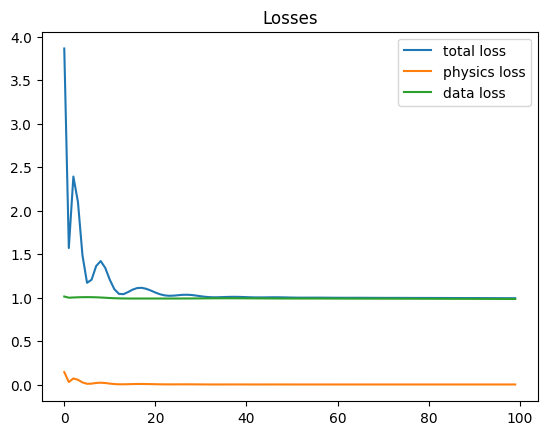

In [15]:
if interactive_plots:
    df = pd.DataFrame({'loss': list_loss, 'loss_pinn': list_loss_physics, 'loss_data': list_loss_data})
    fig = px.line(df, title="Losses")
    fig.update_layout(template="plotly_dark")
    fig.show()
else:
    plt.plot(list_loss, label='total loss')
    plt.plot(list_loss_physics, label='physics loss')
    plt.plot(list_loss_data, label='data loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

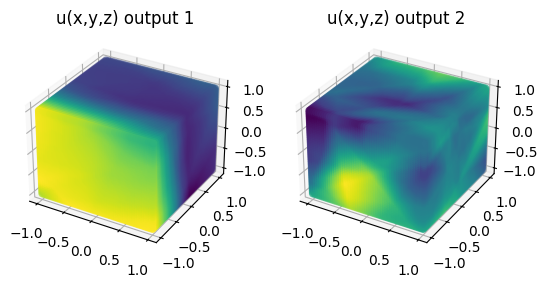

In [16]:
#plot results
if interactive_plots:
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32).to(device)
    output = model(input).to('cpu')
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 0].detach().numpy())
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 1')
    fig.update_layout(template="plotly_dark")
    fig.show()
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 1].detach().numpy())
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 2')
    fig.update_layout(template="plotly_dark")
    fig.show()
else:
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32).to(device)
    output = model(input).to('cpu')
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 0].detach().numpy())
    ax.set_title('u(x,y,z) output 1')
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 1].detach().numpy())
    ax.set_title('u(x,y,z) output 2')
    plt.show()